In [1]:
import maboss
import ginsim
import pandas as pd 
import numpy as np


from identification_patients.get_patients_sens_res import get_patients

from create_generic_models.create_generic_patients_cfgs import create_generic_patients_cfgs_bnds

from create_generic_models.update_phenotypes_generic_models import generic_models_update_phenotypes
from pre_process_data.pre_process_genes import create_table_rna_seq_patients, process_genes

from create_person_models.tailor_cfgs_patients_gene import personalized_patients_genes_cfgs
from create_person_models.tailor_bnd_mutations import personalized_patients_mutations_bnds
from create_person_models.tailor_bnd_tsg_onco_mutations import tailor_bnd_tsg_onco_mut
from create_person_models.tailor_bnd_cnv import tailor_bnd_cnv_cm


from MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, compute_phenotype_mean_group_validation, combine_groups_values, compute_phenotype_mean

from pre_process_data.identify_mutations_patients import identif_mutations_kras_egfr

# # from pre_process_profiles_table_data_lung import create_genes_patients

from stats.stats_proba import compute_mannwhitneyu_test_means
from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from results_MaBoSS_visualization.create_phenotypes_patients_table import vizualise_table_phenotype_condition
from results_MaBoSS_visualization.patients_ids_phenotype_table import create_table_patients_phenotypes
from gene_enrichment.genes_signature import compute_genes_mean_signature
from pre_process_data.preprocess_mutations import preprocess_mutations_ds
from pre_process_data.pre_process_cnv import preprocess_cnv



In [2]:
import os
print(os.getcwd())


/Users/romane/repos/icr/Attractor-Resistance


Step 0: Import data 

In [3]:
# Import Data

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')
mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')




/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_53442/4278837298.py:15: DtypeWarning: Columns (22,50,56,57,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations_data_depseq = pd.read_csv('data/depmap_data/OmicsSomaticMutations.csv')


In [4]:
# chose folder where we want all the personalized boolean models and associated results saved 
drug_interest = 'Refametinib' #Pictilisib, 'Avagacestat' AZD8931 
tissue_interest = 'PAN_CANCER'
tissue_remove = 'Haematopoietic and Lymphoid'

folder_pers_models=f'models/personalized_boolean_{drug_interest}_{tissue_interest}'
folder_result = f'results/{drug_interest}_{tissue_interest}'
folder_result_resistant = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
folder_result_sensitive = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
folder_result_res_sen = f'{folder_result}/sensitive_resistant_results/genes_diff_expressed'


os.makedirs(folder_result_resistant, exist_ok=True)
os.makedirs(folder_result_sensitive, exist_ok=True)
os.makedirs(folder_result_res_sen, exist_ok=True)




# Output directories
output_dir_resistant = f'{folder_pers_models}/resistant_patient/generic_models'
output_dir_sec_resistant = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
output_dir_sensitive = f'{folder_pers_models}/sensitive_patient/generic_models'
output_dir_sec_sensitive = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'
bnd_dir_res = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
bnd_dir_sens = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'

os.makedirs(bnd_dir_sens, exist_ok=True)
os.makedirs(bnd_dir_res, exist_ok=True)

os.makedirs(output_dir_sec_resistant, exist_ok=True)
os.makedirs(output_dir_sec_sensitive, exist_ok=True)


Step 1: Pre-process data- Montagud nodes, rna-seq (filtered with patients IDs and Montagud nodes)

In [5]:
# Pre-process Montagud nodes

# Keep only the nodes of montagud not specific to Prostate 
montagud_nodes = list(set(montagud_data['Target node'].tolist() + montagud_data['Source'].tolist()))
montagud_nodes = [node for node in montagud_nodes if node != '0/1']
montagud_nodes = [node.upper() for node in montagud_nodes if isinstance(node, str)]
to_remove = ['FUSED_EVENT', 'AR_ERG']

montagud_nodes = [node for node in montagud_nodes if node not in to_remove]
montagud_nodes = list(set(montagud_nodes))

Step 1: Check what drug is the best to keep (the one with most resistant and sensitive)

In [6]:
# results = {}
# drug_interests = drug_data['DRUG_NAME'].unique().tolist()

# for drug in drug_interests:
#     top_resistant_ids, top_sensitive_ids, drug_data_filtered = get_patients(500, drug_data, annotations_models, drug, tissue_remove)
#     patients_ids = top_resistant_ids + top_sensitive_ids

#     drug_tissue_filtered = drug_data_filtered[drug_data_filtered['SANGER_MODEL_ID'].isin(patients_ids)]    
#     results[drug] = {
#          "name": drug,
#          "<-1.5": float((drug_tissue_filtered['Z_SCORE'] < -1.5).sum()),
#          ">1.5": float((drug_tissue_filtered['Z_SCORE'] > 1.5).sum()),
#          "mean": float(drug_tissue_filtered['Z_SCORE'].mean()),
#          "std": float(drug_tissue_filtered['Z_SCORE'].std()),
#          "abs_zscore": float(drug_tissue_filtered['Z_SCORE'].abs().mean()),
#      }

# pd_results = pd.DataFrame(results.values())
# pd_results.to_csv(f'{folder_result}/drug_analysis.csv', index=False)




Step 2: Select cancer and drug of interest (tissue_interest, drug_interest)
Get the 100 most sensitive patient
Pre-process data


In [7]:
# Get patients IDs

# changed the drug name to Pictilisib !!!!

# top_resistant_ids, top_sensitive_ids= get_patients(drug_data, annotations_models, drug_interest, tissue_interest)
top_resistant_ids, top_sensitive_ids, drug_tissue_data= get_patients(20, drug_data, annotations_models, drug_interest, tissue_interest = None, tissue_remove = tissue_remove)
patients_ids = top_sensitive_ids + top_resistant_ids

/Users/romane/repos/icr/Attractor-Resistance/identification_patients/get_patients_sens_res.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(


In [8]:
# Pre-process RNA seq data (keep only montagud_nodes and patients ids) and create table for high and low expression
rna_seq_data_filtered = process_genes(patients_ids, montagud_nodes, rna_seq_data)
table_rna_seq_patients = create_table_rna_seq_patients(rna_seq_data_filtered)


/Users/romane/repos/icr/Attractor-Resistance/pre_process_data/pre_process_genes.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={"gene_symbol": "gene_name"}, inplace=True)


In [9]:
# select only the patients id with gene expression data!!

patients_rna_data_res = list(set(table_rna_seq_patients.index) & set(top_resistant_ids))
top_resistant_ids = patients_rna_data_res
# print(top_resistant_ids)
# print(len(top_resistant_ids))


patients_rna_data_sens= list(set(table_rna_seq_patients.index) & set(top_sensitive_ids))
top_sensitive_ids = patients_rna_data_sens
print(top_sensitive_ids)
print(len(top_sensitive_ids))


patients_ids = top_resistant_ids + top_sensitive_ids

['SIDM01001', 'SIDM00284', 'SIDM00056', 'SIDM01240', 'SIDM00337', 'SIDM00826', 'SIDM01242', 'SIDM01066', 'SIDM00129', 'SIDM00910', 'SIDM00003', 'SIDM00175', 'SIDM00568', 'SIDM01059', 'SIDM00890', 'SIDM00974', 'SIDM00795', 'SIDM00190', 'SIDM00619']
19


In [10]:
# mutations_data_filtered_combined = preprocess_mutations_ds(patients_ids, models_depmap_annotation, mutations_data_depseq,montagud_nodes)
# print(mutations_data_filtered_combined)

In [11]:
# preprocess cnv
cnv_data_filtered = preprocess_cnv(cnv_data, montagud_nodes,patients_ids)
print(cnv_data_filtered)

         model_id gene_symbol  total_copy_number cn_category
2313    SIDM00003        BCL2                2.0        Loss
2502    SIDM00003         SMO                5.0        Gain
2570    SIDM00003         JUN                4.0        Gain
2591    SIDM00003        EZH2                5.0        Gain
2594    SIDM00003         ERG                4.0        Gain
...           ...         ...                ...         ...
875480  SIDM01242         VHL                2.0        Loss
875691  SIDM01242       FGFR3                2.0        Loss
875825  SIDM01242       MED12                5.0        Gain
875947  SIDM01242       FOXA1                2.0        Loss
875957  SIDM01242        BCL2                1.0        Loss

[459 rows x 4 columns]


Step 3: Create generic boolean networks with the sensitive and resistant ID names


In [12]:
folder_generic_models_cfg = 'models/generic_models/Montagud2022_PAN_Cancer.cfg'
folder_generic_models_bnd = 'models/generic_models/Montagud2022_PAN_Cancer.bnd'
# create_generic_patients_cfgs_bnds(folder_generic_models_cfg, folder_generic_models_bnd, folder_pers_models, top_resistant_ids, top_sensitive_ids, drug_interest, tissue_interest)


In [13]:
# specify the phenotypes of interest for the analysis

phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Migration","Apoptosis"]
original_data_dir_res = "models/personalized_boolean_Refametinib_PAN_CANCER/resistant_patient/generic_models"
results_dir_res = "models/personalized_boolean_Refametinib_PAN_CANCER/resistant_patient/generic_models"

original_data_dir_sens = "models/personalized_boolean_Refametinib_PAN_CANCER/sensitive_patient/generic_models"
results_dir_sens = "models/personalized_boolean_Refametinib_PAN_CANCER/sensitive_patient/generic_models"

# generic_models_update_phenotypes(phenotype_interest, original_data_dir_res, results_dir_res)
# generic_models_update_phenotypes(phenotype_interest, original_data_dir_sens, results_dir_sens)


Step 4: Personalize the cfg files with genes/ proteins


In [14]:
print(output_dir_resistant)
print(output_dir_sec_resistant)

print(table_rna_seq_patients.head())
print(drug_interest)

models/personalized_boolean_Refametinib_PAN_CANCER/resistant_patient/generic_models
models/personalized_boolean_Refametinib_PAN_CANCER/resistant_patient/personalized_boolean_modified/models_gene_expression
gene_expression_level                               High Gene Expression  \
model_id                                                                   
SIDM00003              ATM, EEF2K, ERG, ETS1, ETV1, LDHA, PTCH1, RUNX...   
SIDM00056              ATM, BAD, BAX, BMP2, CFLAR, EGFR, ETS1, ETV1, ...   
SIDM00129                                          AXIN1, FADD, MYC, SMO   
SIDM00175                           ATM, ATR, ETS1, MDM2, MXI1, NF1, SMO   
SIDM00183              BIRC5, BRCA1, COX4I2, E2F1, EP300, ETV1, EZH2,...   

gene_expression_level                                Low Gene Expression  
model_id                                                                  
SIDM00003                                                          FOXA1  
SIDM00056                           

In [15]:
# only three modif for resistant
# personalized_patients_genes_cfgs(rna_seq_data, montagud_nodes, output_dir_resistant, output_dir_sec_resistant, patients_ids, table_rna_seq_patients, drug_interest)
# personalized_patients_genes_cfgs(rna_seq_data, montagud_nodes, output_dir_sensitive, output_dir_sec_sensitive, patients_ids, table_rna_seq_patients, drug_interest)

Step 5: Identification of which patients id have KRAS or EGFR mutation
personalize the bnd files with the mutations common to Lung (KRAS/ EGFR):

In [16]:
# personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_res, drug_interest)
# personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_sens, drug_interest)

In [17]:
print(cnv_data_filtered.head())

       model_id gene_symbol  total_copy_number cn_category
2313  SIDM00003        BCL2                2.0        Loss
2502  SIDM00003         SMO                5.0        Gain
2570  SIDM00003         JUN                4.0        Gain
2591  SIDM00003        EZH2                5.0        Gain
2594  SIDM00003         ERG                4.0        Gain


In [18]:
# tailor_bnd_cnv_cm(cnv_data_filtered,bnd_dir_res, bnd_dir_sens, drug_interest)

In [19]:
# tailor_bnd_tsg_onco_mut(mutations_data_filtered_combined,bnd_dir_res, bnd_dir_sens, drug_interest)

Step 6: compute the phenotype distribution 

In [20]:
# dic_patient_resistant =f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
# dic_patient_sensitive =f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'
# phenotypes_list = phenotype_interest
# inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'Carcinogen']
# patient_res_data_dict = compute_phenotypes_distribution(phenotypes_list, folder_result, dic_patient_resistant, inputs_list, drug_interest, 'resistant')
# patient_sens_data_dict = compute_phenotypes_distribution(phenotypes_list, folder_result, dic_patient_sensitive, inputs_list, drug_interest, 'sensitive')
# patients_res_df_mean, patients_res_df_std, stats_results_data_res_df = compute_mean_patients(patient_res_data_dict)
# patients_sens_df_mean, patients_sens_df_std, stats_results_data_sens_df = compute_mean_patients(patient_sens_data_dict)
# patients_res_df_mean.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv', index=True)
# patients_res_df_std.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_std_{drug_interest}.csv', index=True)
# stats_results_data_res_df.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv', index=True)
# stats_results_data_sens_df.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv', index=True)
# patients_sens_df_mean.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv', index=True)
# patients_sens_df_std.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_std_{drug_interest}.csv', index=True)



In [ ]:
# Compute phenotype distribution for each patient
folder_models_res = 'models/personalized_boolean_Refametinib_PAN_CANCER/resistant_patient/personalized_boolean_modified/models_gene_expression'
folder_save_results_res = 'results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients' 
folder_models_sens = 'models/personalized_boolean_Refametinib_PAN_CANCER/sensitive_patient/personalized_boolean_modified/models_gene_expression'
folder_save_results_sens = 'results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients' 

phenotypes_interest = [
        "Proliferation",
        "Invasion",
        "DNA_Repair",
        "Migration",
        "Apoptosis",
    ]


inputs_list = ['EGF', 'FGF', 'TGFB', 'Androgen', 'Hypoxia', 'Nutrients', 'Carcinogen', 'Acidosis', 'TNF', 'SPOP']
for patient  in top_resistant_ids:
    compute_phenotype_table(folder_save_results_res, folder_models_res, patient, inputs_list, phenotypes_interest, 'Refametinib')
    
# for patient  in top_sensitive_ids:
#     compute_phenotype_table(folder_save_results_sens, folder_models_sens, patient, inputs_list, phenotypes_interest, 'Refametinib')
    

In [22]:
# compute mean


folder_groups_means_res = "results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients"
results_mean_folder_res = "results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_mean"
# to do-> change name (only compute mean not validation)
# mean_df =compute_phenotype_mean(["resistant"], folder_groups_means_res, results_mean_folder_res)


folder_groups_means_sens = "results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients"
results_mean_folder_sens = "results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_mean"
# to do-> change name (only compute mean not validation)
# mean_df =compute_phenotype_mean(["sensitive"], folder_groups_means_sens, results_mean_folder_sens)

In [23]:
# combine data together 

from collections import defaultdict

def collect_group_data(group_folder_path):
    combined_data = defaultdict(lambda: defaultdict(list))

    for file in os.listdir(group_folder_path):
        if file.startswith("_SID") and file.endswith(".csv"):
            file_path = os.path.join(group_folder_path, file)
            df = pd.read_csv(file_path, index_col=0)

            for input_name in df.index:
                for phenotype in df.columns:
                    value = df.at[input_name, phenotype]
                    combined_data[input_name][phenotype].append(float(value))

    result_df = pd.DataFrame.from_dict(combined_data, orient='index')
    result_df.to_csv(os.path.join(group_folder_path, "combined_results.csv"))

    return result_df


# base_path_res = "results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients"
# group_df_res = collect_group_data(base_path_res)
# print(group_df_res)

base_path_sens = "results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients"
group_df_sens = collect_group_data(base_path_sens)
print(group_df_sens)


                                                Proliferation  \
EGF         [0.503272, 0.54511, 0.136023, 0.932629, 0.1429...   
FGF         [0.4091310000000001, 0.5043740000000001, 0.232...   
TGFB        [0.107505, 0.052012, 0.087705, 0.036, 0.045484...   
Androgen    [0.503272, 0.54511, 0.136023, 0.932629, 0.1429...   
Hypoxia     [0.154323, 0.146067, 0.158, 0.068011, 0.044286...   
Nutrients   [0.5690930000000001, 0.5562769999999999, 0.271...   
Carcinogen  [0.460381, 0.538814, 0.094366, 0.938, 0.131709...   
Acidosis    [0.2995939999999999, 0.523883, 0.088713, 0.96,...   
TNF         [0.002, 0.01, 0.05, 0.043803, 0.061924, 0.0407...   
SPOP        [0.46583, 0.518912, 0.157442, 0.958, 0.430778,...   

                                                     Invasion  \
EGF         [0.983328, 0.439463, 0.575635, 0.0, 0.988, 0.9...   
FGF         [0.880793, 0.449415, 0.5591710000000001, 0.0, ...   
TGFB        [0.915381, 0.8796689999999999, 0.616398, 0.948...   
Androgen    [0.983328, 0

In [24]:
# stats test between the two combined dataframes (sensitive vs resistant)

res_combined_path = "results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv"
sens_combined_path = "results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv"


df_res_combined = pd.read_csv(res_combined_path, index_col=0)  # index: inputs, columns: phenotypes
df_sens_combined = pd.read_csv(sens_combined_path, index_col=0)

print(df_res_combined)
# print(df_sens_combined)

                                                Proliferation  \
EGF         [0.92918, 0.909378, 0.908251, 0.428, 0.894, 0....   
FGF         [0.938718, 0.919125, 0.902001, 0.3953810000000...   
TGFB        [0.460338, 0.0279999999999999, 0.4027619999999...   
Androgen    [0.92918, 0.909378, 0.908251, 0.428, 0.894, 0....   
Hypoxia     [0.044585, 0.937924, 0.4604860000000001, 0.344...   
Nutrients   [0.875383, 0.90786, 0.921016, 0.452596, 0.8967...   
Carcinogen  [0.972832, 0.952, 0.9260010000000004, 0.508136...   
Acidosis    [0.929179, 0.94105, 0.941122, 0.28306000000000...   
TNF         [0.016745, 0.041798, 0.359102, 0.068123, 0.373...   
SPOP        [0.966731, 0.935537, 0.936498, 0.3033620000000...   

                                                     Invasion  \
EGF         [0.976017, 0.002, 0.487973, 0.5930660000000001...   
FGF         [0.98015, 0.0, 0.4878309999999999, 0.569032000...   
TGFB        [0.969412, 0.975738, 0.538737, 0.7134990000000...   
Androgen    [0.976017, 0

In [25]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import pandas as pd 
import ast


kruskal_results = pd.DataFrame(index=inputs_list, columns=phenotypes_interest)

for input_name in inputs_list:
    for phenotype in phenotypes_interest:
        group1 = df_res_combined.at[input_name, phenotype]
        group2 = df_sens_combined.at[input_name, phenotype]
        group1 = ast.literal_eval(group1)
        group2 = ast.literal_eval(group2)

        if group1 and group2:
            stat, pvalue = kruskal(group1, group2)
            kruskal_results.at[input_name, phenotype] = pvalue
        else:
            kruskal_results.at[input_name, phenotype] = None
print(kruskal_results)



significant_kruskal_results = kruskal_results.applymap(lambda x: x if (x is not None and float(x) < 0.05) else np.nan)
print(significant_kruskal_results)


           Proliferation  Invasion DNA_Repair Migration Apoptosis
EGF             0.214688  0.418884   0.583958  0.164361   0.45657
FGF             0.140391  0.725204   0.477989  0.085907   0.71516
TGFB            0.017342  0.389103   0.811206  0.138143  0.661426
Androgen        0.214688  0.418884   0.583958  0.164361   0.45657
Hypoxia         0.025523  0.792508   0.672753  0.353539  0.128961
Nutrients       0.184059  0.558321   0.276302  0.132198  0.261014
Carcinogen      0.031888  0.529758    0.57883  0.108791  0.650895
Acidosis        0.156792  0.769652   0.857777  0.167961  0.439081
TNF             0.007884  0.090382     0.7793  0.151867  0.156792
SPOP            0.165518  0.404221   0.397784  0.045725  0.342655
            Proliferation  Invasion  DNA_Repair  Migration  Apoptosis
EGF                   NaN       NaN         NaN        NaN        NaN
FGF                   NaN       NaN         NaN        NaN        NaN
TGFB             0.017342       NaN         NaN        NaN      

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_53442/987139639.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  significant_kruskal_results = kruskal_results.applymap(lambda x: x if (x is not None and float(x) < 0.05) else np.nan)


Step 7: Compute stats test between two mean datasets

In [26]:
# patient_res_stats_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
# patient_sens_stats_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')

patient_res_stats_values =  pd.read_csv("results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv")
patient_sens_stats_values = pd.read_csv("results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv")
compute_mannwhitneyu_test_means(folder_result,patient_res_stats_values, patient_sens_stats_values, drug_interest)

Step 8: Vizualise the boxplot of phenotype distribution output

In [27]:
# patient_res_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
# patient_sens_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
#data_greater_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')


patient_res_values = pd.read_csv('results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv')
patient_sens_values = pd.read_csv('results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv')
data_greater_side = pd.read_csv('results/Refametinib_PAN_CANCER/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_Refametinib.csv')

data_less_side = pd.read_csv("results/Refametinib_PAN_CANCER/sensitive_resistant_results/p_values_df_mannwhitneyu_less_sign_Refametinib.csv")
data_both_side = pd.read_csv("results/Refametinib_PAN_CANCER/sensitive_resistant_results/p_values_df_mannwhitneyu_two_sides_Refametinib.csv")

signif_df = pd.concat([data_greater_side, data_less_side, data_both_side], axis=0)


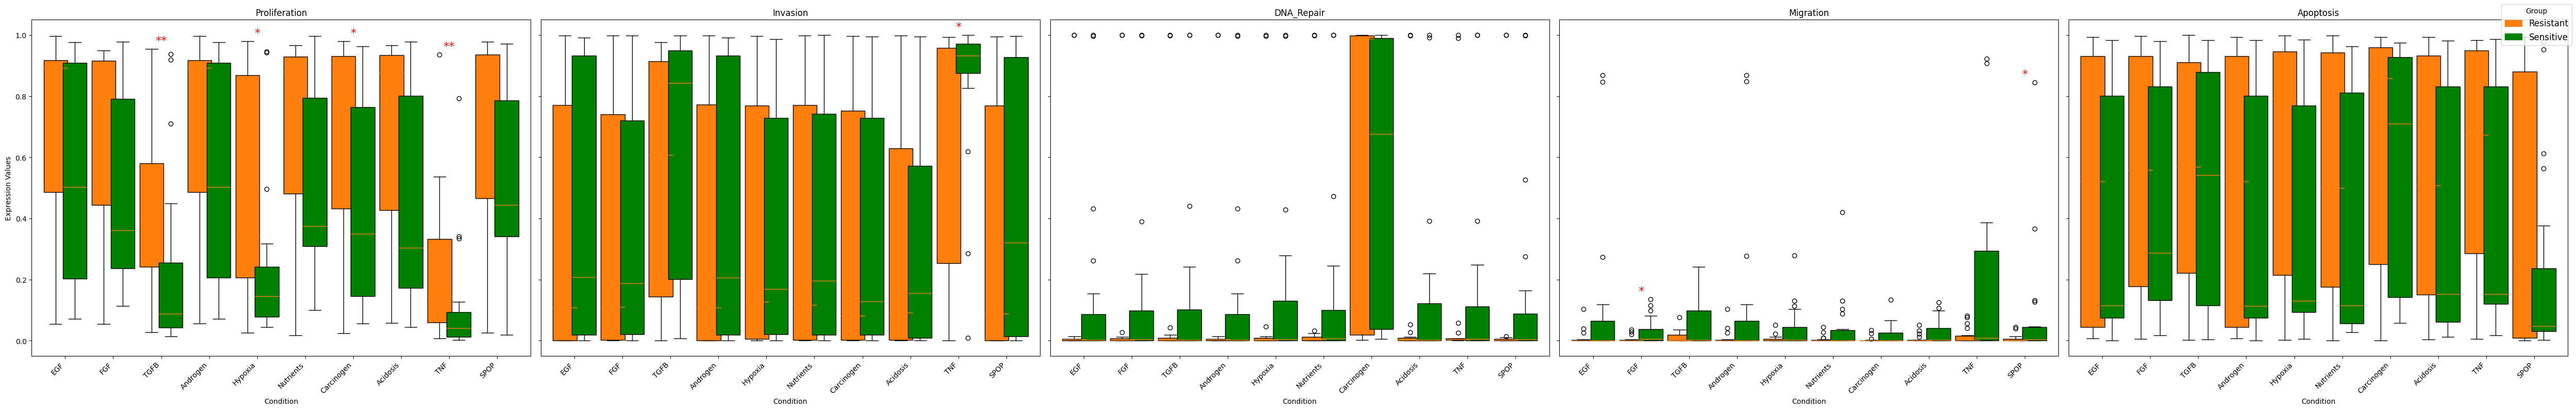

In [28]:
create_boxplot(patient_res_values, patient_sens_values, signif_df)


Step 9: create table of patients with conditions- phenotype

In [ ]:
# dir_res_data = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
# dir_sens_data = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
# patients_phenot_table = create_table_patients_phenotypes(folder_result, dir_res_data, dir_sens_data)

Loaded data for combined_results, shape: (10, 5)
Loaded data for _SIDM00892, shape: (10, 5)
Loaded data for _SIDM00716, shape: (10, 5)
Loaded data for _SIDM00920, shape: (10, 5)
Loaded data for _SIDM00506, shape: (10, 5)
Loaded data for _SIDM00881, shape: (10, 5)
Loaded data for _SIDM01056, shape: (10, 5)
Loaded data for _SIDM00770, shape: (10, 5)
Loaded data for _SIDM00767, shape: (10, 5)
Loaded data for _SIDM01120, shape: (10, 5)
Loaded data for _SIDM00971, shape: (10, 5)
Loaded data for _SIDM00631, shape: (10, 5)
Loaded data for _SIDM00183, shape: (10, 5)
Loaded data for _SIDM00292, shape: (10, 5)
Loaded data for _SIDM00870, shape: (10, 5)
Loaded data for _SIDM00508, shape: (10, 5)
Loaded data for _SIDM00444, shape: (10, 5)
Loaded data for _SIDM00524, shape: (10, 5)
Loaded data for _SIDM00255, shape: (10, 5)
Loaded data for _SIDM00719, shape: (10, 5)
Loaded data for combined_trans_results, shape: (6, 10)
Loaded data for combined_results, shape: (10, 5)
Loaded data for _SIDM00890, sh

/Users/romane/repos/icr/Attractor-Resistance/results_MaBoSS_visualization/patients_ids_phenotype_table.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  patients_phenot_table.at[patient, col_name] = value
/Users/romane/repos/icr/Attractor-Resistance/results_MaBoSS_visualization/patients_ids_phenotype_table.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  patients_phenot_table.at[patient, col_name] = value
/Users/romane/repos/icr/Attractor-Resistance/results_MaBoSS_visualization/patients_ids_phenotype_table.py:65: Performa

Step 10: Create heatmap figure 

In [ ]:
# patient_resistant_mean = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv')
# patient_sensitive_mean = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv')
# vizualise_table_phenotype_condition(folder_result, patient_resistant_mean, patient_sensitive_mean)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_Refametinib.csv'

Step 11: Identify genes differently expressed in the patients with high 

In [ ]:
# patients_phenot_table = pd.read_csv(f'{folder_result}/sensitive_resistant_results/patients_phenot_table.csv')
# genes_stats_results_metast_TGFb,  len_resistant_group_id_metast_TGFb, len_sensitive_group_ids_metast_TGFb = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Metastasis', 'TGFb', patients_phenot_table, top_resistant_ids, top_sensitive_ids)
# genes_stats_results_prolif_egf,  len_resistant_group_ids_prolif_egf, len_sensitive_group_ids_prolif_egf = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Proliferation', 'EGF', patients_phenot_table, top_resistant_ids, top_sensitive_ids)

In [ ]:
# print(len_resistant_group_id_metast_TGFb)
# print(len_sensitive_group_ids_metast_TGFb)

# print(len_resistant_group_ids_prolif_egf)
# print(len_sensitive_group_ids_prolif_egf)

Step 11: check there is not correlation between phenotype distribution and cancer type 


In [ ]:
# patients_phenot_table['SANGER_MODEL_ID'] = patients_phenot_table['Unnamed: 0'].str.split('_').str[0]
# conditions = [
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_resistant_ids),
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_sensitive_ids)
#     ]
# choices = ['Resistant', 'Sensitive']
# patients_phenot_table.loc[:,'Drug status'] = np.select(conditions, choices, default = '')



# ids_tissue_data = drug_tissue_data[['SANGER_MODEL_ID', 'tissue']]
# ids_tissue_data = ids_tissue_data.drop_duplicates(subset='SANGER_MODEL_ID')


# # merge tissues and model id 
# patients_phenot_table = pd.merge(patients_phenot_table, ids_tissue_data, on = 'SANGER_MODEL_ID')



# # look the number of each cancer for the condition-phenotype of interest
# condition = 'TGFb'
# phenotype = 'Metastasis'


# # resistant group changes according to what is the condition and the phenotype
# # group_proliferation_resistant: group with high phenotype 

# group_phenotype_resistant = patients_phenot_table[
#     (patients_phenot_table['Drug status'] == 'Resistant') & 
#     (patients_phenot_table[f'{condition}_ON_{phenotype}'] >= 0.1)
# ]

# # print(group_phenotype_resistant['tissue'].value_counts()) # EGF- proliferation: 4 lung, 1 breast, 1 haematopoetic
# #                                                           # TGFb- Metastasis: 21 haemato, 2 skin, 2 breast, 1 lung, 1 large intestine, 1 endom, 1 liver


In [ ]:
# inputs = ['EGF', 'FGF', 'Nutrients', 'Androgen']
# results = []
# output_dir = f'{folder_result}/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients'
# os.makedirs(output_dir, exist_ok=True)
# cfg_files = [f for f in os.listdir(dic_patient_sensitive) if f.endswith(f"{drug_interest}.cfg")]
# for cfg_file in cfg_files:
#     cfg_path = os.path.join(dic_patient_sensitive, cfg_file)
#     base_name = os.path.splitext(cfg_file)[0]
#     bnd_path = os.path.join(dic_patient_sensitive, base_name + ".bnd")
#     model = maboss.load(bnd_path, cfg_path)
#     for input_node in inputs:
#         model.network.set_istate(input_node, [0.0, 1.0])  # ON
#     result = model.run()
#     probtraj = result.get_last_states_probtraj()
#     probtraj["Patient_ID"] = base_name
#     results.append(probtraj)
# combined_df = pd.concat(results, ignore_index=True)
# combined_csv_path = os.path.join(output_dir, "all_patients_all_inputs_on_probtraj.csv")
# combined_df.to_csv(combined_csv_path, index=False)
# print(f"Saved combined results to: {combined_csv_path}")


In [ ]:
# results_resistant = pd.read_csv('results/resistant_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')
# results_sensitive = pd.read_csv('results/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')



# print('Apoptosis')

# resistant_apopto_mean = results_resistant['Apoptosis'].mean()
# print(resistant_apopto_mean)

# sensitive_apopto_mean = results_sensitive['Apoptosis'].mean()
# print(sensitive_apopto_mean)



# print('Proliferation')
# resistant_prolif_mean = results_resistant['Proliferation'].mean()
# print(resistant_prolif_mean)

# sensitive_prolif_mean = results_sensitive['Proliferation'].mean()
# print(sensitive_prolif_mean)



# print('Metastasis')
# resistant_metas_mean = results_resistant['Metastasis'].mean()
# print(resistant_metas_mean)

# sensitive_metas_mean = results_sensitive['Metastasis'].mean()
# print(sensitive_metas_mean)


In [ ]:
# TO DO: later- changes EGF and TGF initial states according to expression
